In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import csv

%matplotlib inline
pd.options.display.max_colwidth = 144

# Loading
First of all load all the data (files) we need for this project
- the enhanced twitter file provided
- the prediction file residing on the internet
- the twitter archive by means of the twitter api 


In [2]:
df_twitter = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
df_twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


In [4]:
# open the url
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r=requests.get(url)

# check if it can be retrieved if so read/write the file
if r.status_code == 200:
    if url.find('/'):
        prediction_file_name = url.rsplit('/', 1)[1]              
        open(prediction_file_name,'wb').write(r.content)
    
else:
    print('open did not succeed')

In [5]:
# reopen the file and create a dataframe for it
df_predict= pd.read_csv(prediction_file_name,sep='\t')
df_predict.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [6]:
# the twitter api is in a seperate file for ease of developing this notebook
# therefore the call to read_twitter is commented out during development (used once to create the file)

from Read_twitter import read_twitter
tweets_id=list(df_twitter.tweet_id)

#read_twitter(tweets_id)

#read the file from twitter back into the notebook
df_extra=pd.read_json('tweets_json.txt',lines=True)
df_extra.head(1)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indic...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-b...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


#  Assessment of the data

Start with some general views and describtions of the data


In [7]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
df_twitter.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [9]:
df_twitter.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

There are colums with null variables in the dataset. 
The in reply to columns we will not need and can be removed.
We look only into tweets, lets check out the retweets.

In [10]:
#a few data rows with retweets
df_twitter[['tweet_id','text', 'retweeted_status_id']].iloc[880:895,:]
# retweets are marked in the text with RT @.......

,tweet_id,text,retweeted_status_id
880,760539183865880579,This is Atlas. Swinging is his passion. 12/10 would push all day https://t.co/9k8LLjJ0uJ,NaN
881,760521673607086080,"Doggo want what doggo cannot have. Temptation strong, dog stronger. 12/10 https://t.co/IqyTF6qik6",NaN
882,760290219849637889,This is Rocco. He's doing his best. 13/10 someone help him (IG: rocco_roni) https://t.co/qFsl1nnXMv,NaN
883,760252756032651264,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP,NaN
884,760190180481531904,Meet Sadie. She's addicted to balloons. It's tearing her family apart. Won't admit she has a problem. Still 10/10 https://t.co/h6s9Rch0gZ,NaN
885,760153949710192640,"RT @hownottodraw: The story/person behind @dog_rates is heckin adorable af. 11/10, probably would pet. https://t.co/AG5UnRrmzJ",7.601538e+17
886,759943073749200896,Here's a wicked fast pupper. 12/10 camera could barely keep pup https://t.co/HtAR6gpUAu,NaN
887,759923798737051648,We only rate dogs... this is a Taiwanese Guide Walrus. Im getting real heckin tired of this. Please send dogs. 10/10 https://t.co/49hkNAsubi,NaN
888,759846353224826880,This is Kirby. He's a Beneblip Cumberpat. Pretty heckin rare. 11/10 would put my face against his face https://t.co/fd6uucghY6,NaN
889,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4D...",NaN


There are indeed rows which are retweets for example row 885. Have to be removed from the dataset.

Next check out the source column it is an object

In [11]:
df_twitter.source.sample(5)

1148    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
622     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
2026    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
187     <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1182    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
Name: source, dtype: object

In [12]:
df_twitter.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

The source column contains URL's they can be shortend and changed in a catagorical value.

The tweet id is an int64 however the twitter documentation (https://developer.twitter.com/en/docs/twitter-ids) suggest to store it in a string object. Hence it has to be changed.

In [13]:
df_twitter.tweet_id.dtype,df_predict.tweet_id.dtype,df_extra.id.dtype

(dtype('int64'), dtype('int64'), dtype('int64'))

The tweet_id is in all three dataframes an int64. Change it in all three
Check if there are duplicates.

In [14]:
#check for duplicates
df_twitter.duplicated('tweet_id').sum()

0

No duplicates found. 

Ratings are int64 types. However a rating could be a fraction number e.g 13.5 therefore a float is better.
As learned from the text the extracting is not always correct.

In [15]:
df_twitter.text.sample(10)

691                   This is Lincoln. He forgot to use his blinker when he changed lanes just now. Guilty as h*ck. Still 10/10 https://t.co/lsrR83SiVp
1365                                                           This is Lucy. She's sick of these bullshit generalizations 11/10 https://t.co/d2b5C2R0aO
542     We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZi...
425        RT @dog_rates: This is Sampson. He just graduated. Ready to be a doggo now. Time for the real world. 12/10 have fun with taxes https://t.co…
116     This is Rumble, but he's not ready to. Would rather fall asleep in his bath bucket. 13/10 would attempt a boop without waking https://t.co/M...
1261            This is Lacy. She's tipping her hat to you. Daydreams of her life back on the frontier. 11/10 would pet so well https://t.co/fG5Pk3Et1I
372     Meet Doobert. He's a deaf doggo. Didn't stop him on the field tho. Absolute lege

In [16]:
df_twitter.query('tweet_id == "680494726643068929"')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


The rating should be extracted again as it is not correct as can be seen from above example. 

Next is the name of the dog. Get a list of the names

In [17]:
df_twitter['name'].value_counts()

None        745
a            55
Charlie      12
Cooper       11
Lucy         11
           ... 
Halo          1
Geoff         1
Pancake       1
Sundance      1
Fwed          1
Name: name, Length: 957, dtype: int64

We observe a list with names. Never heard of a dog called 'a'. Lets check for lower case names
Also  as can been seen, in the above examples a number of text lines contains dognames others don't. If it has a dogname it is starting with a capital letter.  Thus 'Charlie' would be a dogname and 'light' would be no.

In [18]:
df_twitter['name'].str.extract('(^[a-z][a-z]*)').value_counts()

a               55
the              8
an               7
very             5
quite            4
one              4
just             4
mad              2
actually         2
not              2
getting          2
incredibly       1
all              1
this             1
by               1
his              1
such             1
infuriating      1
space            1
light            1
unacceptable     1
my               1
officially       1
old              1
life             1
dtype: int64

The list with lower case names contains no actual dognames. This column has to be cleaned. We will not extract the dognames again but stay with the already extracted dognames.

We also see in the dataframe the dog stages 'doggo', 'floofer', 'puppo', 'pupper' these should be in one column. This is not tidy.

Next we check the prediction data

In [19]:
df_predict.info(),df_predict.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


(None, (2075, 12))

In [20]:
df_predict.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
767,689275259254616065,https://pbs.twimg.com/media/CZDMMY0WEAAQYjQ.jpg,1,American_Staffordshire_terrier,0.215161,True,Chesapeake_Bay_retriever,0.079051,True,Doberman,0.070226,True
1103,721503162398597120,https://pbs.twimg.com/media/CgNLS1PW8AAxWSN.jpg,3,Pomeranian,0.997750,True,Chihuahua,0.001248,True,Pekinese,0.000775,True
678,683498322573824003,https://pbs.twimg.com/media/CXxGGOsUwAAr62n.jpg,1,Airedale,0.945362,True,Irish_terrier,0.026850,True,Lakeland_terrier,0.016826,True
576,678675843183484930,https://pbs.twimg.com/media/CWskEqnWUAAQZW_.jpg,1,maze,0.339850,False,streetcar,0.099688,False,sundial,0.084808,False
1807,832397543355072512,https://pbs.twimg.com/media/C41FIiAW8AA7lMr.jpg,1,Pekinese,0.988916,True,Brabancon_griffon,0.001677,True,Siamese_cat,0.001126,False
540,676975532580409345,https://pbs.twimg.com/media/CWUZpydWcAAeipD.jpg,1,malamute,0.363257,True,Siberian_husky,0.245862,True,Eskimo_dog,0.125547,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
291,671182547775299584,https://pbs.twimg.com/media/CVCE9uYXIAEtSzR.jpg,1,Rottweiler,0.331179,True,kelpie,0.218601,True,Appenzeller,0.182520,True
784,690021994562220032,https://pbs.twimg.com/media/CZNzV6cW0AAsX7p.jpg,1,badger,0.289550,False,weasel,0.099140,False,malamute,0.040696,True
1188,739544079319588864,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False


In [21]:
df_predict.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [22]:
df_predict.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


The dataframe column types are usefull for the purpose they serve. The names can be more meaningfull.

Next the extra data extracted from twitter

In [23]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   id                             2331 non-null   int64              
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

We only use the favorite and retweet count from this table. No further cleaning is therefore needed in this table.

With three seperate tables it is usefull to  combine the three into one table for further investigation. This is a tidyness issue.

## Summary assesments
1. In the above example we observe retweets. They have to be removed.
2. The columns with retweet data is not needed en have to be removed. Also the in reply to columns are not needen and can be removed.
3. As can be seen from the field description the Time stamp is an object should be a date time object
4. The source field contains URL
5. twitter tweet_id should be a string object. This holds also for the othe two dataframes.
6. Rating should be a float 
6. Rating is not always correct extracted
7. Dognames are not correct contains non names.
8. The dog stages are columns instead of a single column with all satges. (tidyness problem)
9. The column names in the prediction database can be more descriptive
10. Combine the three tables in one maeningfull table. (tidyness problem)



# Solving Quality problems


#### In the enhanced twitter data

1. [Contains retweets](#retweets)
Enhanced twitter file contains retweets as described in the project plan. 
The retweet status is an indacation for that.

2. [Remove alle not needen columns](#remove)

3. [Timestamp is not datetime object](#timestamp)
The Timestamp field should be a datetime field instead of a object field

4. [Source field should be catagorical](#source)
The source field contains only four different URL's. Better to transform it in a catagorical dtype. For analysis it is easier to make it a shorter value

5. [Tweetid should be string](#tweetid)
The tweetid is a Int64 but should be a string

6. [The rating should be a float](#ratings)
7. [The ratings are not correct extracted](#ratings)

8. [Dognames not correct](#dognames)
Not all the names in the column name are actual dognames. This should be cleaned.

#### In the prediction data

9. [Column names in prediction file](#predict)
The column names are not very descriptive. Should be changed in more meaningfull names.

#### In the data from twitter
The data as extracted from twitter will only be used to get the retweet count and favorites count. Details of the columns can be found in this document: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet
No further cleaning therefore conducted


### Tidiness problem enhanched twitter data
1. [doggo, floofer, pupper and puppo](#puppo)
are values should be in one column instead of four.

2. [Combine in one dataframe](#combine)
The three dataframes should be combined. They form one set of obeservations.


## Copy the dataframes

Perform the assesment on the original dataframes, perform the cleaning on the copied dataframes.

In [24]:
clean_twitter = df_twitter.copy()
clean_predict = df_predict.copy()
clean_extra = df_extra.copy()

# Cleaning!
<a id='retweets'></a>
### 1. Retweets

#### Define
Remove all retweets from the extended twitter dataframe. We want only tweets for this project.

In [25]:
clean_twitter.query('tweet_id == 759566828574212096') #Tweet with a retweet

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
890,759566828574212096,NaN,NaN,2016-07-31 01:50:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 https://t.co/zxw8d5g94P,7.395441e+17,4.196984e+09,2016-06-05 19:47:03 +0000,"https://twitter.com/dog_rates/status/739544079319588864/photo/1,https://twitter.com/dog_rates/status/739544079319588864/photo/1",10,10,None,None,None,None,None


In [26]:
clean_twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


This is a link to twitter to the page belonging to the above tweet
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">This is Phineas. He&#39;s a mystical boy. Only ever appears in the hole of a donut. 13/10 <a href="https://t.co/MgUWQ76dJU">pic.twitter.com/MgUWQ76dJU</a></p>&mdash; WeRateDogs® (@dog_rates) <a href="https://twitter.com/dog_rates/status/892420643555336193?ref_src=twsrc%5Etfw">August 1, 2017</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 


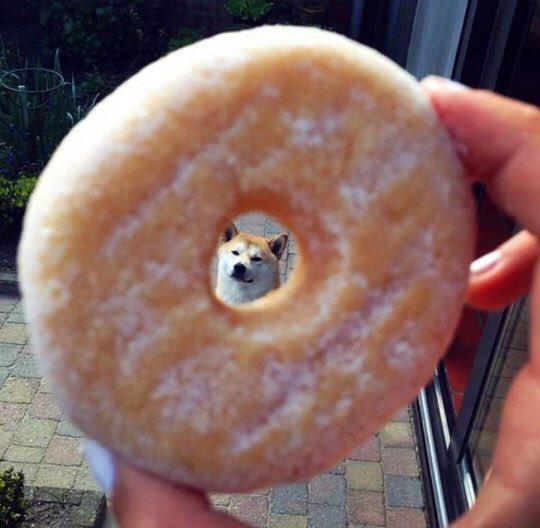

#### Code

In [27]:
#We need only tweets, retweets are indicated with retweet_status_id, in total
#181 rows have to be deleted from the frame. 

total_rows=clean_twitter.shape[0]

#create df with all none empty retweet_status_id
a=clean_twitter.retweeted_status_id.dropna()

#remove all rows in the temporary dataframe from the twitter dataframe.
clean_twitter.drop(labels=a.index,inplace=True)

#### Test

In [28]:
#Test if the 181 rows are gone. 2356 - 181 = 2175
clean_twitter.info()
print('Removed lines: {}'.format(total_rows - clean_twitter.shape[0]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [29]:
clean_twitter.query('tweet_id == 759566828574212096')
# no outpute expected

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [30]:
clean_twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


<a id='remove'></a> 
### 2 Remove not needed columns

#### Define
Remove the in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,retweeted_status_user_id, retweeted_status_timestamp

#### Code

In [31]:
#Remove the 2 reply* columns and the 3 retweet* colums
total_columns=clean_twitter.shape[1]
clean_twitter = clean_twitter.drop(['in_reply_to_status_id','in_reply_to_user_id'],axis=1)
clean_twitter = clean_twitter.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)

#### Test
Print the column list and count the number of removed columns which should be 5

In [32]:
clean_twitter.info()
# below the 5 columns should have gone
print('Removed columns: {}'.format(total_columns - clean_twitter.shape[1]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2175 non-null   int64 
 6   rating_denominator  2175 non-null   int64 
 7   name                2175 non-null   object
 8   doggo               2175 non-null   object
 9   floofer             2175 non-null   object
 10  pupper              2175 non-null   object
 11  puppo               2175 non-null   object
dtypes: int64(3), object(9)
memory usage: 220.9+ KB
Removed columns: 5


<a id='timestamp'></a>
### 3 Change Timestamp

#### Define
Time stamp should be a date time object instead of an object

#### Code


In [33]:
#convert the timestamp to a datetime object 
#(from df_twitter.info 3   timestamp                   2356 non-null   object)
clean_twitter.timestamp = pd.to_datetime(clean_twitter.timestamp)

#### Test
Check the column type

In [34]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

In [35]:
clean_twitter.timestamp.head(1)

0   2017-08-01 16:23:56+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

<a id='source'></a>
### 4. Change source column

#### Define
Source is object change it to catagorical after replacing the URL content to shorter descriptions.

#### Code


In [36]:
#There are only 4 values in URL format replace it with a shorthand notation
clean_twitter.source=clean_twitter.source.str.extract('(iPhone|Vine|Web|TweetDeck)')

#Check the result
clean_twitter.source.value_counts()

iPhone       2042
Vine           91
Web            31
TweetDeck      11
Name: source, dtype: int64

In [37]:
#Change the type to category 
#(from df_twitter.info  4   source                      2356 non-null   object)
clean_twitter.source=clean_twitter.source.astype('category')

#### test

Check the type

In [38]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

<a id='tweetid'></a>
### 5. Tweet_id convert to string

#### Define
The tweetid can be very long according the twitter specification a string object is preferd

#### Code

In [39]:
#the column tweet_id should be of type object not Int64
clean_twitter.tweet_id = clean_twitter.tweet_id.astype(str)
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

In [40]:
#the column tweet_id should be of type object not Int64
clean_predict.tweet_id = clean_predict.tweet_id.astype(str)

In [41]:
#Tweet_id is called id in this dataframe, we rename it to have all the same names
clean_extra.id = clean_extra.id.astype(str)
clean_extra.rename(columns={'id':'tweet_id'},inplace=True)

#### Test

In [42]:
clean_twitter.tweet_id.dtype,clean_predict.tweet_id.dtype,clean_extra.tweet_id.dtype

(dtype('O'), dtype('O'), dtype('O'))

<a id='ratings'></a>
### 6&7. Ratings

#### Define
- Convert numerator and denominator to type float
- extract the ratings again from the tweets

#### Code


In [43]:
#convert to floats
clean_twitter = clean_twitter.astype({'rating_numerator': 'float', 'rating_denominator': 'float'})

In [44]:
#From the text extract number followed by / followed by number where number can be nn.nn or nn
clean_twitter[['rating_numerator','rating_denominator']]=clean_twitter.text.str.extract('([0-9]+\.?[0-9]*)\/([0-9]+\.?[0-9]*)')

#### Test

In the assesment we found  value of 11.26 and 13.5 check if these are extracted correct

In [45]:
#search for a floating value 11.26 and 13.5 checking if they are correct extracted
clean_twitter[clean_twitter.text.str.contains('11.26')]['tweet_id']

1712    680494726643068929
Name: tweet_id, dtype: object

In [46]:
clean_twitter.query('tweet_id == "680494726643068929"')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10


In [47]:
clean_twitter[clean_twitter.text.str.contains('13.5')]['tweet_id']

45    883482846933004288
Name: tweet_id, dtype: object

In [48]:
clean_twitter.query('tweet_id == "883482846933004288"')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5,10


In [49]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   object             
 6   rating_denominator  2175 non-null   object             
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

As can be seen, fields are onverted to floats and contain fraction numbers. 

<a id='dognames'></a>
### 8. Dognames

#### Define
Clean the columns name by removing all values beginning with a lower case letter. 

#### Code

In [50]:
#Create a new column with a meaningfull name 
clean_twitter['dogname']=clean_twitter.name.str.replace('(^[a-z][a-z]*)','None')

In [51]:
#Crosscheck
clean_twitter[['name','dogname']].sample(25)

,name,dogname
136,Coco,Coco
172,None,None
587,Sobe,Sobe
306,None,None
1202,Bluebert,Bluebert
948,None,None
1524,Lolo,Lolo
1730,Bruce,Bruce
940,Tayzie,Tayzie
1902,None,None


#### Test

In [52]:
#Another check, no Names starting with a lower letter: should be empty
clean_twitter['dogname'].str.extract('(^[a-z][a-z]*)').sum()

0    0.0
dtype: float64

In [53]:
#Remove the old column name from the dataframe
clean_twitter.drop(columns='name',axis=1,inplace=True)

In [54]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   object             
 6   rating_denominator  2175 non-null   object             
 7   doggo               2175 non-null   object             
 8   floofer             2175 non-null   object             
 9   pupper              2175 non-null   object             
 10  puppo               2175 non-null   object             
 11  dogname             2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

In [55]:
clean_twitter.shape

(2175, 12)

<a id='predict'></a>
### 9. Meaningfull column names

#### Define
The prediction has three predictions in row, each with a breed {P1..P3}, a Confidence level {P1_conf...P3_conf} and a boolean indicating if it is a dog or not.

The names will be changed to
- First_guess, Second_guess, Third_guess
- First_confidence, Second_confidence, Third_confidence
- First_dog, Second_dog, Third_dog

#### Code

In [56]:
clean_predict.rename(columns={'p1': 'First_breed',
                              'p2': 'Second_breed',
                              'p3': 'Third_breed'}, inplace=True)

In [57]:
clean_predict.rename(columns={'p1_conf': 'First_confidence',
                              'p2_conf': 'Second_confidence',
                              'p3_conf': 'Third_confidence'}, inplace=True)

In [58]:
clean_predict.rename(columns={'p1_dog': 'First_dog',
                              'p2_dog': 'Second_dog',
                              'p3_dog': 'Third_dog'}, inplace=True)

#### Test

In [59]:
clean_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           2075 non-null   object 
 1   jpg_url            2075 non-null   object 
 2   img_num            2075 non-null   int64  
 3   First_breed        2075 non-null   object 
 4   First_confidence   2075 non-null   float64
 5   First_dog          2075 non-null   bool   
 6   Second_breed       2075 non-null   object 
 7   Second_confidence  2075 non-null   float64
 8   Second_dog         2075 non-null   bool   
 9   Third_breed        2075 non-null   object 
 10  Third_confidence   2075 non-null   float64
 11  Third_dog          2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


<a id='tidy'></a><a id='puppo'></a>
### Tidiness
There are two issues to resolve

#### Define
1. The doge stages should be in one column instead of four
2. The tables should be combined to one meaningfull dataset

#### Code doge stages

In [60]:
#create a new column with all dog stages in the column, replace None in the same action replace('', np.nan, inplace=True)
clean_twitter['stage'] = clean_twitter[['doggo', 'floofer','pupper','puppo']].apply(lambda x: "".join(x).replace('None',''), axis=1)

In [61]:
#check the result
clean_twitter.stage.value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

In [62]:
#we have to correct a few values
clean_twitter.stage=clean_twitter.stage.str.replace('doggop','doggo,p')
clean_twitter.stage=clean_twitter.stage.str.replace('doggof','doggo,f')
#remove the obsolete columns
clean_twitter.drop(columns=['doggo', 'floofer','pupper','puppo'],inplace=True)

#### Test the dogstages

In [63]:
clean_twitter.stage.value_counts(),clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   object             
 6   rating_denominator  2175 non-null   object             
 7   dogname             2175 non-null   object             
 8   stage               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC](1), object(7)
memory usage: 155.2+ KB


(                 1831
 pupper            224
 doggo              75
 puppo              24
 doggo,pupper       10
 floofer             9
 doggo,puppo         1
 doggo,floofer       1
 Name: stage, dtype: int64,
 None)

In [64]:
clean_twitter.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dogname,stage
1742,679462823135686656,2015-12-23 00:45:35+00:00,iPhone,Meet Hurley. He's the curly one. He hugs every other dog he sees during his walk. 11/10 for spreading the love https://t.co/M6vqkt2GKV,https://twitter.com/dog_rates/status/679462823135686656/photo/1,11,10,Hurley,
297,837110210464448512,2017-03-02 01:20:01+00:00,iPhone,This is Clark. He passed pupper training today. Round of appaws for Clark. 13/10 https://t.co/7pUjwe8X6B,https://twitter.com/dog_rates/status/837110210464448512/photo/1,13,10,Clark,pupper
108,871515927908634625,2017-06-04 23:56:03+00:00,iPhone,This is Napolean. He's a Raggedy East Nicaraguan Zoom Zoom. Runs on one leg. Built for deception. No eyes. Good with kids. 12/10 great doggo...,"https://twitter.com/dog_rates/status/871515927908634625/photo/1,https://twitter.com/dog_rates/status/871515927908634625/photo/1",12,10,Napolean,doggo
624,795464331001561088,2016-11-07 03:14:10+00:00,iPhone,Elder doggo does a splash. Both 13/10 incredible stuff https://t.co/gBUDjdEcqz,https://twitter.com/dog_rates/status/795464331001561088/video/1,13,10,None,doggo
239,846874817362120707,2017-03-29 00:01:05+00:00,iPhone,"This is Tuck. As you can see, he's rather h*ckin rare. Taken seriously until his legs are seen. Tail stuck in a permanent zoom. 13/10 https:...","https://twitter.com/dog_rates/status/846874817362120707/photo/1,https://twitter.com/dog_rates/status/846874817362120707/photo/1",13,10,Tuck,


 <a id='combine'></a>
 ### Create one final dataframe
 
 #### Code create final dataframe

In [65]:
clean_twitter.shape, clean_extra.shape, clean_predict.shape

((2175, 9), (2331, 32), (2075, 12))

In [66]:
#create first a temporary dataframe with the data needed from the archive
df_tmp=clean_twitter.merge(clean_extra, on='tweet_id', how='left')[['tweet_id','retweet_count','favorite_count']]

In [67]:
df_tmp.head(3)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7454.0,35309.0
1,892177421306343426,5535.0,30560.0
2,891815181378084864,3661.0,23002.0


In [68]:
#Merge this with the twitter data
twitter_tmp=pd.merge(clean_twitter,df_tmp,on='tweet_id', how='inner' )
twitter_tmp.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dogname,stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,,7454.0,35309.0
1,892177421306343426,2017-08-01 00:17:27+00:00,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 h...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,,5535.0,30560.0
2,891815181378084864,2017-07-31 00:18:03+00:00,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZn...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,,3661.0,23002.0


In [69]:
#create the final dataframe with also the predicted data
twitter_master=pd.merge(twitter_tmp,clean_predict,on='tweet_id', how='left')


#### Test the final dataframe

In [70]:
twitter_master.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dogname,stage,retweet_count,...,img_num,First_breed,First_confidence,First_dog,Second_breed,Second_confidence,Second_dog,Third_breed,Third_confidence,Third_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,,7454.0,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 h...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,,5535.0,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:00,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZn...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,,3661.0,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [71]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   object             
 6   rating_denominator  2175 non-null   object             
 7   dogname             2175 non-null   object             
 8   stage               2175 non-null   object             
 9   retweet_count       2168 non-null   float64            
 10  favorite_count      2168 non-null   float64            
 11  jpg_url             1994 non-null   object             
 12  img_num             1994 non-null 

In [72]:
list(twitter_master)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'dogname',
 'stage',
 'retweet_count',
 'favorite_count',
 'jpg_url',
 'img_num',
 'First_breed',
 'First_confidence',
 'First_dog',
 'Second_breed',
 'Second_confidence',
 'Second_dog',
 'Third_breed',
 'Third_confidence',
 'Third_dog']

In [73]:
#write the cleaned data to a file
twitter_master.to_csv('twitter_archive_master.csv')

## Insights

    1 Is there a relation between the number of retweets and the favorites count.
    2 Which dog breeds are most detected by the neural network and how often it missed a real dog.
    3 Which dog names are most favorit and do the appear in the top 500 dogname list
    4 What are the ratings for the dogs compared tp the stage it is in.

### 1 Relation between retweets and favorits

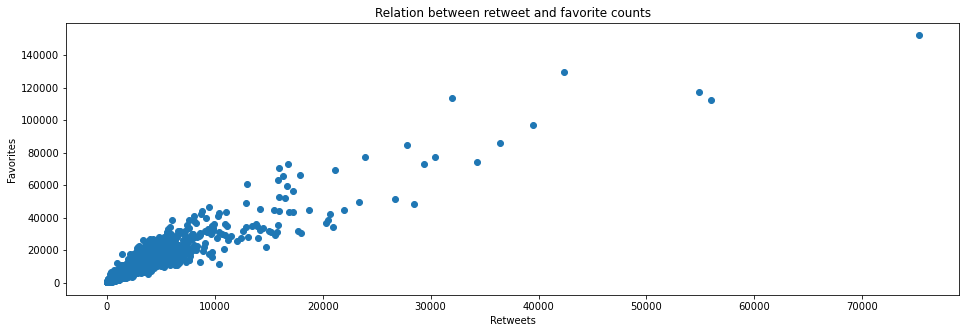

In [74]:
# Create a scatterplot checking the relation between retweet_count and favorite_count.
plt.figure(figsize = [16, 5])
base_color = sns.color_palette()[0]
plt.scatter(data=twitter_master, x='retweet_count', y='favorite_count',color=base_color);
plt.title('Relation between retweet and favorite counts');
plt.xlabel('Retweets');
plt.ylabel('Favorites');

In [75]:
#To assess if there is a relation between the retweet_count and the favorite count 
#we check the correlation between the two columns
twitter_master.retweet_count.corr(twitter_master.favorite_count)

0.9264850985242625

As can be seen from the scatterplot and the calculation of the correlation. There is a strong positive relation between the retweet_count and the favorit count. In other words tweets retweeted often are also favorite.

### 2 Detecting dogbreed
We split it in two question.
- What is the ratio between dog/none dog detection
- what are the top most dog breeds


In [76]:
# The ratio between dog and none dog detection
twitter_master.First_dog.mean(skipna=True), twitter_master.Second_dog.mean(skipna=True), twitter_master.Third_dog.mean(skipna=True)

(0.7407221664994985, 0.7497492477432297, 0.7251755265797393)

In [77]:
#what is detected instead of a dog Breed?
twitter_master.query('First_dog == False')['First_breed'].value_counts().head(10)

seat_belt      21
teddy          18
web_site       15
tennis_ball     9
dingo           9
hamster         7
Siamese_cat     7
bath_towel      7
doormat         7
swing           7
Name: First_breed, dtype: int64

In [78]:
#The top ten dog breads for the first, second and third prediction
twitter_master['First_breed'].value_counts().head(10)

golden_retriever      139
Labrador_retriever     95
Pembroke               88
Chihuahua              79
pug                    54
chow                   41
Samoyed                40
Pomeranian             38
toy_poodle             38
malamute               29
Name: First_breed, dtype: int64

In [79]:
twitter_master['Second_breed'].value_counts().head(10)

Labrador_retriever          96
golden_retriever            82
Cardigan                    72
Chihuahua                   43
Chesapeake_Bay_retriever    40
French_bulldog              39
Pomeranian                  39
toy_poodle                  36
Siberian_husky              33
cocker_spaniel              32
Name: Second_breed, dtype: int64

In [80]:
twitter_master['Third_breed'].value_counts().head(10)

Labrador_retriever           76
Chihuahua                    57
golden_retriever             46
Eskimo_dog                   36
kelpie                       33
kuvasz                       31
chow                         31
Staffordshire_bullterrier    30
beagle                       30
toy_poodle                   29
Name: Third_breed, dtype: int64

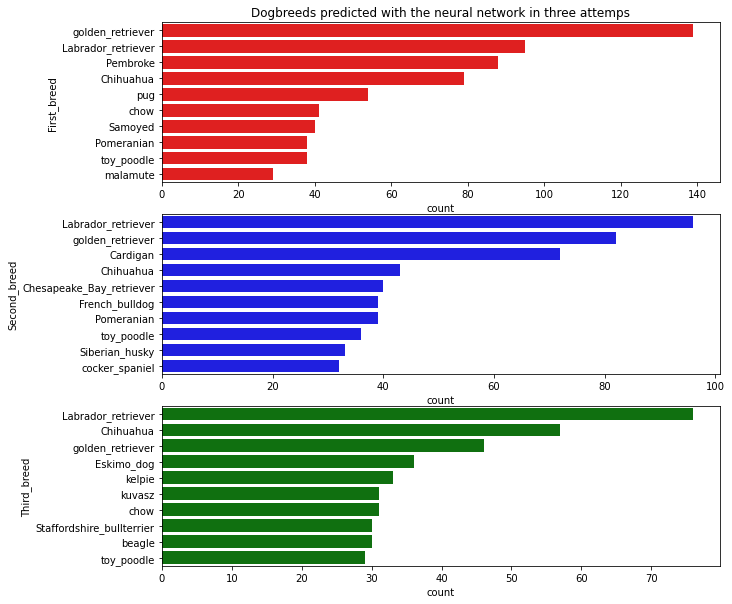

In [81]:
#lets do the same for all three the predictions but visual
plt.figure(figsize = [10, 10])
plt.subplot(3,1,1)
plt.title('Dogbreeds predicted with the neural network in three attemps');
sns.countplot(y='First_breed',data=twitter_master,order=pd.value_counts(twitter_master['First_breed']).iloc[:10].index, color='r');
plt.subplot(3,1,2)
sns.countplot(y='Second_breed',data=twitter_master,order=pd.value_counts(twitter_master['Second_breed']).iloc[:10].index, color='b');
plt.subplot(3,1,3)
sns.countplot(y='Third_breed',data=twitter_master,order=pd.value_counts(twitter_master['Third_breed']).iloc[:10].index, color='g');

As can bee seen from the above code, the prediction gives approximatly 3 out of 4 times a dog breed.

Most of the time the prediction network predicts a 'golden retriever' or 'labrador retriever'. 
This is not an indication that the breed is detected correctly for that to conclude the prediction should be held against the actual dog breed to verify.

### 3 Favorite dognames
A list of favorite dognames is retrieved from the website: www.puppyleaks.com/popular-dog-names and put into a file

In [82]:
# read the file with the top 500 dognames
dognames=[]
with open('dognames.txt', mode='r',newline='\n') as dogfile:
    dogname=dogfile.readlines()
    for row in dogname:
        dognames.append(row.strip('\n\r'))
        
#convert it to a set
dognames=set(dognames)


In [83]:
#create set with all dognames in the tweets
alldognames = set(twitter_master.dogname.unique())


In [84]:
#combine sets such that the resulting set contains names in both sets
populardognames=alldognames.intersection(dognames)


In [85]:
#create two lists with the names and count
names=[]
values=[]
for key, value in twitter_master.dogname.value_counts(sort=True).to_dict().items():
    if key in populardognames:
        names.append(key)
        values.append(value)
names[:15]

['Charlie',
 'Cooper',
 'Oliver',
 'Penny',
 'Tucker',
 'Sadie',
 'Lola',
 'Winston',
 'Daisy',
 'Toby',
 'Oscar',
 'Bailey',
 'Bella',
 'Koda',
 'Bo']

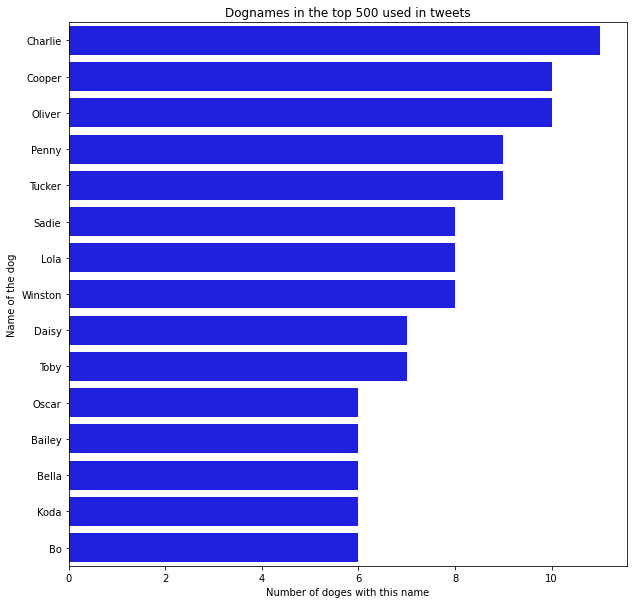

In [86]:
# use the above list to plot the top 15 dognames
plt.figure(figsize = [10, 10])
sns.barplot(y=names[:15],x=values[:15],color='b',orient='h');
plt.xlabel('Number of doges with this name');
plt.ylabel('Name of the dog');
plt.title('Dognames in the top 500 used in tweets');

In [87]:
#From the top 500 list the following 15 dognames are als favorite in the tweets
names[:15]

['Charlie',
 'Cooper',
 'Oliver',
 'Penny',
 'Tucker',
 'Sadie',
 'Lola',
 'Winston',
 'Daisy',
 'Toby',
 'Oscar',
 'Bailey',
 'Bella',
 'Koda',
 'Bo']

In [88]:
#Taking the top 15 dognames in the tweets will reveil that not all top names in the tweets are in the top 500
# for example Lucy is not (rank 2) and 
twitter_master.dogname.value_counts(sort=True).head(16)

None       784
Charlie     11
Lucy        11
Cooper      10
Oliver      10
Penny        9
Tucker       9
Sadie        8
Lola         8
Winston      8
Daisy        7
Toby         7
Oscar        6
Bailey       6
Bella        6
Koda         6
Name: dogname, dtype: int64

Shown above is the list with the popular dognames. Most of the names found in the tweets are also in the top 500 of popular dognames. 

### 4 Ratings as part of the stage

In [89]:
tmp_master=twitter_master.copy()
tmp_master = tmp_master.query('stage != ""')
dog_stages = ['doggo', 'puppo', 'pupper', 'floofer']
dog_stages=['floofer','puppo','doggo', 'pupper']
vclasses = pd.api.types.CategoricalDtype(ordered=True, categories=dog_stages)
tmp_master['stage'] = tmp_master['stage'].astype(vclasses);
tmp_master['divider'] = tmp_master.favorite_count/tmp_master.retweet_count
tmp_master.divider.median()

3.291032608695652

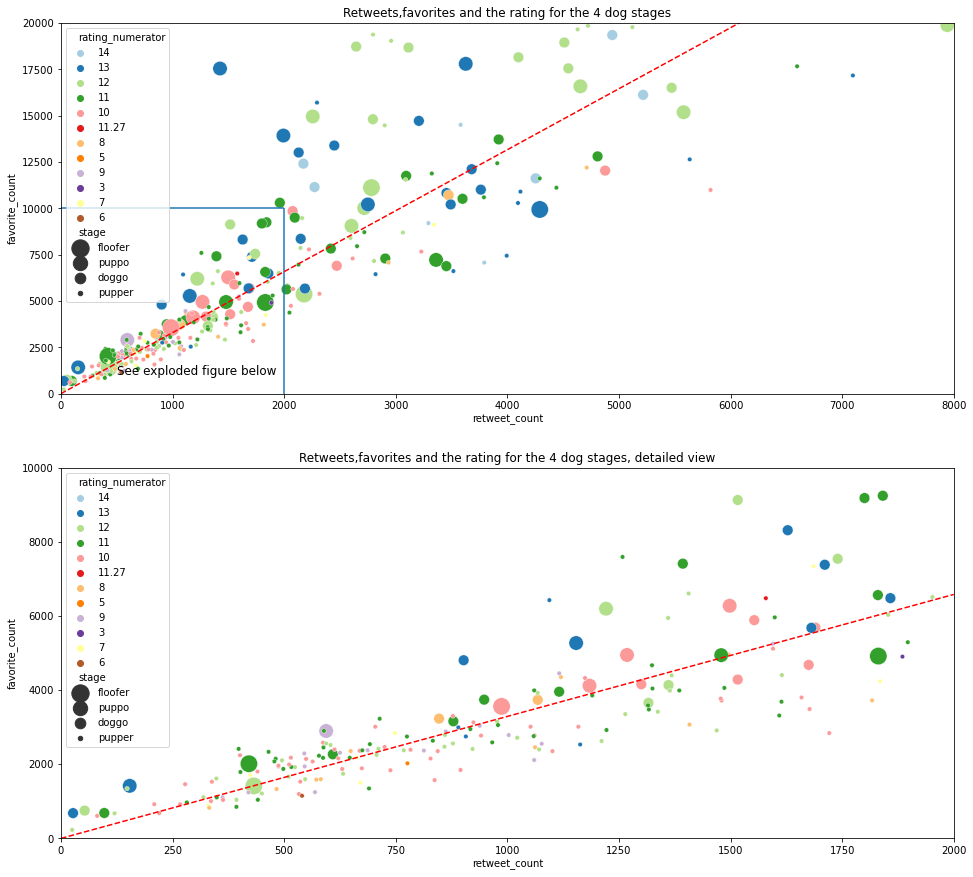

In [90]:
plt.figure(figsize = [16, 15])

plt.subplot(2,1,1)
plt.xlim(0,8000)
plt.ylim(0,20000)
base_color = sns.color_palette()[0]
sns.scatterplot(data=tmp_master, 
                x='retweet_count', y='favorite_count',palette='Paired',size='stage', 
                hue='rating_numerator',sizes=(20,300),
                markers=['o','v','p','h']);
plt.vlines(2000,0,10000)
plt.hlines(10000,2000,0)
plt.text(500,1000,"See exploded figure below",fontsize=12)
plt.title("Retweets,favorites and the rating for the 4 dog stages");
x=[0,8000]
y=[0,3.291*8000]
plt.plot(x,y, color='r',linestyle='--');

plt.subplot(2,1,2)
plt.xlim(0,2000)
plt.ylim(0,10000)
base_color = sns.color_palette()[1]
sns.scatterplot(data=tmp_master, 
                x='retweet_count', y='favorite_count',palette='Paired',size='stage', 
                hue='rating_numerator',sizes=(20,300),
                markers=['o','v','p','h']);
plt.title("Retweets,favorites and the rating for the 4 dog stages, detailed view");
x=[0,2000]
y=[0,3.291*2000]
plt.plot(x,y, color='r',linestyle='--');

From the two figures above we can see that the stage of the dog has some impact on the number of retweets and favorites. The floofer and the puppo in general have higher counts. Be aware that these present a smaller part of the total dog's in this overview.

Also can be seen that the retweet counts are lower than the favorites count. The red dashed line is the line with a slope of 3,29 which is the median of the difference between the two. The floofer and puppo are the dogs which in general are above the line meaning that they seems to be even more favorite then the puppers.

In general we can not conclude that the rating of the dog (color coded) is dependend on  the stage. It seems there is a smalle favour for higher ratings for the floofer en puppo more investigation would be needed.